# Formalia:

Please read the [assignment overview page](https://github.com/suneman/socialgraphs2025/wiki/Assignments) carefully before proceeding. This page contains information about formatting (including formats etc), group sizes, and many other aspects of handing in the assignment. 

_If you fail to follow these simple instructions, it will negatively impact your grade!_

**Due date and time**: The assignment is due on Tuesday September 30th, 2025 at 23:55. Hand in your IPython notebook file (with extension `.ipynb`) via DTU Learn

# Imports

In [1]:
import networkx as nx
import random
import matplotlib.pyplot as plt
import numpy as np
import re
import requests
import os
import pickle
from io import BytesIO

# Assignment 1.1: Exploring WS and BA models

This first part draws on the Watts-Stogatz and Barabasi-Albert models from Week 3. You should provide solutions to the exercises with the following titles from **Part 1** 

* *Did you really read the text? Answer the following questions (no calculations needed) in your IPython notebook*

* *WS edition*

And from **Part 2**

* *BA Edition*.
  * **Note**: The second part of this exercise (after the questions to the text) first has you build a BA network step-by-step, but doesn't ask any questions. For that part, I would simply like you to write well-documented code that shows how you build the network. 


# Assignment 1.1
## Part 1: Small World Networks

**Exercises:** Did you really read the text? Answer the following questions (no calculations needed) in your IPython notebook.
- **Q:** What's the problem with random networks as a model for real-world networks according to the argument in section 3.5 (near the end)?
- **A:** The problem with random networks is that the Poisson distribution does not describe real-world networks well. In a Poisson model, most nodes have a degree close to the average, and the difference between minimum, average, and maximum degree stays very small. In reality, networks show much larger variation: big hubs appear quickly as the network grows, and many outliers exist that the Poisson model would predict as almost impossible. This is shown in the graphs comparing Poisson with data from the Internet, collaborations, and proteins, and also with the example of Franklin D. Roosevelt, who had far more connections than expected. Therefore, random networks fail to capture the heterogeneity of real systems.
- **Q:** List the four regimes that characterize random networks as a function of $⟨k⟩$
- **A:**
    1. **Subcritical Regime: $0 < ⟨k⟩ < 1$**
        - Network consists of many tiny clusters, no GCC (Giant Connected Component)
        - Larges component has size $N_G ∼ ln(N)$
    2. **Critical Point: $⟨k⟩ = 1$**
        - Transition point between no GCC and the emergence of one
        - Largest component grows with $N_G ∼ N_{2/3}$, but still vanishes relative to N
        - Component sizes follow a power law distribution
    3. **Supercritical Regime: $⟨k⟩ > 1$**
        - The GCC appears, and it contains a finite fraction of the nodes
        - Small tree-like components coexist with the GCC
    4. **Connected Regime: $⟨k⟩ > ln(N)$**
        - The giant component absorbs essentially all nodes, so the graph is connected with high probability
        - The network is still sparse (average degree only $ln(N)$)
        - The graph becomes complete only at $⟨k⟩ = N - 1$
- **Q:** According to the book, why is it a problem for random networks (in terms of being a model for real-world networks) that the degree-dependent clustering  $C(k)$ decreases as a function of  $k$ in real-world networks?
- **A:** Random networks predict that the clustering coefficient decreases as $1/N$ and is independent of node degree. This means, that if you take a random network, all nodes should have the same clustering, no matter how many links they have. In real networks, however, clustering is much higher than predicted and does not vanish with system size. More importantly, the clustering coefficient $C(k)$ decreases with degree. Hubs have lower clustering than low-degree nodes. This shows that random networks fail to capture an important property of real systems: the coexistence of high clustering and hubs. Therefore, they are not good models for the local structure of real-world networks.

**Exercises:** WS edition.
- **Q:** First, let's use `networkx` to play around with WS graphs. Use `nx.watts_strogatz_graph` to generate 3 graphs with 500 nodes each, average degree = 4, and rewiring probablity $p = 0, 0.1,$ and  $1$. Calculate the average shortest path length $\langle d \rangle$ for each one.
- **A:** Setup the graphs:

In [2]:
G1 = nx.watts_strogatz_graph(500, 4, 0)
G2 = nx.watts_strogatz_graph(500, 4, 0.1)
G3 = nx.watts_strogatz_graph(500, 4, 1)

- **A:** Calculate shortest paths:

In [3]:
print(f"The average shortest path length of Graph 1 is: {nx.average_shortest_path_length(G1):.2f}")
print(f"The average shortest path length of Graph 2 is: {nx.average_shortest_path_length(G2):.2f}")
print(f"The average shortest path length of Graph 3 is: {nx.average_shortest_path_length(G3):.2f}")

The average shortest path length of Graph 1 is: 62.88
The average shortest path length of Graph 2 is: 7.88
The average shortest path length of Graph 3 is: 4.75


- **Q:** Describe what happens to the network when $p = 1$.
- **A:** When $p=1$, the average shortest path length drops to a very small value—much smaller than for $p=0$ or $p=0.1$, and approaches the random-graph limit. This happens because nodes are rewired with a high probability to faraway nodes, creating shortcuts that make most node pairs only a few steps apart.

- **Q:** Generate a lot of networks with different values of $p$. You will notice that paths are short when $p$ is close to one and they are long when $p = 0$. What's the value of $p$ for which the average shortest path length gets close to the short paths we find in a fully randomized network.
- **A:** Generating the graphs:

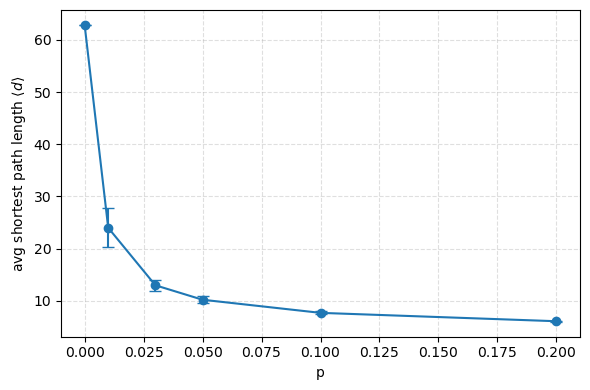

In [4]:
# p values
p_values = [0, 0.01, 0.03, 0.05, 0.1, 0.2]

# setting up the graphs
graphs = [
    [nx.watts_strogatz_graph(500, 4, p) for _ in range(50)]
    for p in p_values
]
# Calculate the average shortest paths
ds = [
    np.mean([nx.average_shortest_path_length(g) for g in graphs_for_p])
    for graphs_for_p in graphs
]
# Calculate the standard deviations
stds = [
    np.std([nx.average_shortest_path_length(g) for g in graphs_for_p])
    for graphs_for_p in graphs
]

# Create the plot
plt.figure(figsize=(6,4))
plt.errorbar(
    p_values, ds, yerr=stds,
    marker='o', linestyle='-', capsize=4
)
plt.xlabel("p")
plt.ylabel(r"avg shortest path length $\langle d \rangle$")
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

**Image 1.1:
Average shortest path length in the Watts–Strogatz model.**

The figure shows how the average shortest path length $⟨d⟩$ depends on the rewiring probability $p$ in Watts–Strogatz networks with $N=500$ and $k=4$. Each point is the mean over 50 realizations, and the error bars represent the standard deviation. The results demonstrate that even a very small amount of rewiring quickly reduces $⟨d⟩$, as long-range shortcuts appear. This illustrates the small-world phenomenon, networks can stay highly clustered while their paths become very short.

## Part 2 - Scale-Free Networks
**Exercises:** BA edition.
- **Q:** What are the three slope dependent regimes of complex networks with power-law degree distributions? Briefly describe each one. (You will have to skim chp 4.7 to answer this one).
- **A:**
    - **Anomalous Regime (y <= 2)** - the number of links connected to the largest hub grows as fast as the size of the network (the degree of the largest hub must exceed the total nr of nodes in the network), meaning it will run out of nodes to connect to.

    - **Scale-Free Regime (2 < y <3**) - a network where most nodes have very few links and a few nodes have a ton of links. Those hubs act as shortcuts, so any two nodes are only a handful of steps apart (ultra-small world).

    - **Random Network Regime (y > 3)** - hubs are smaller and rearer, degrees are more balanced. Both the first and second moments are finite, for large y the degree distribution decays sufficiently fast to make the hubs small and less numerous. They are hard to distinguish from a random network.

- **Q:** What are the three regimes we find in non-linear preferential attachement? (chapter 5) Briefly describe each one.
- **A:**
    - **Sublinear (alfa < 1)** - weak rich-get-richer, meaning high-degree nodes aren't favored strongly, no mega hubs.

    - **Linear (alfa=1)** - exact rich-get-richer, meaning the people with more connections are more likely to get even more connections (grow), clear hubs.

    - **Superlinear (alfa > 1)** - too strong rich get richer - popular nodes are favored too strongly, one dominant hub emerges.

- **Q:** We're going to create our own Barabasi-Albert model (a special case) in right in a `notebook`. Follow the recipe below for success:
    - First create a graph consisting of a single link. (You can call the nodes anything, but I would simply use integers as names).
    - Now add another node, connecting one of the existing nodes in proportion to their degree.
    - Keep going until you have a 100 node network.
    - *Hint*: The difficult part here is connecting to each node according to their degree. The way I do it is: generate a list of all edges (e.g. pairs of nodes), then flatten it (e.g. remove connection information). That list contains each node in proportion to its connections, thus drawing a random node from that list (e.g. using `random.choice`) corresponds to selecting a node with probability proportional to it's degree.
    - Plot the network.


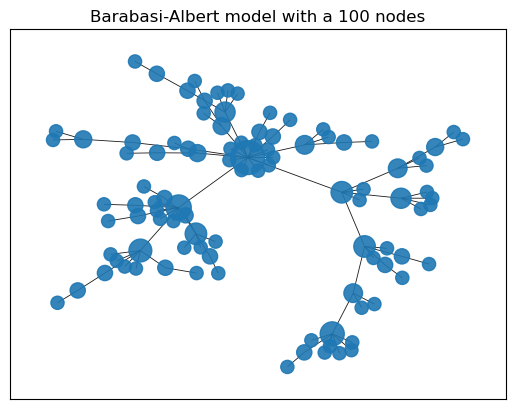

In [5]:
# To make it reproducible
random.seed(42)
np.random.seed(42)

# Creating a graph
G = nx.Graph()
G.add_edge(0,1)

next_node = 2

while G.number_of_nodes() < 100:
    G.add_node(next_node)
    
    # Builds a list of edge endpoints, nodes appear as many times as their degree
    edge_ends = [n for (u,v) in G.edges() for n in (u,v)]

    # Picking a random target
    target = random.choice(edge_ends)

    # Attaching the new node to the target
    G.add_edge(next_node, target)
    next_node +=1

pos = nx.spring_layout(G, seed=7)
deg = dict(G.degree())
node_sizes = [60 + 30 * deg[n] for n in G.nodes()] # build the node sizes for plotting based on each node's degree

plt.figure()
nx.draw_networkx(G, pos=pos, node_size=node_sizes, with_labels=False, width=0.6, alpha=0.9)
plt.title("Barabasi-Albert model with a 100 nodes")
plt.show()


- **Q:**
    - Add more nodes until you have a 5000 node network.
    - What's the maximum and minimum degree?
    - Now, bin the degree distribution using `numpy.histogram`.
    - Plot the distribution. Plot it with both linear and log-log axes.
- **A:**

Minimum degree: 1
Maximum degree: 134


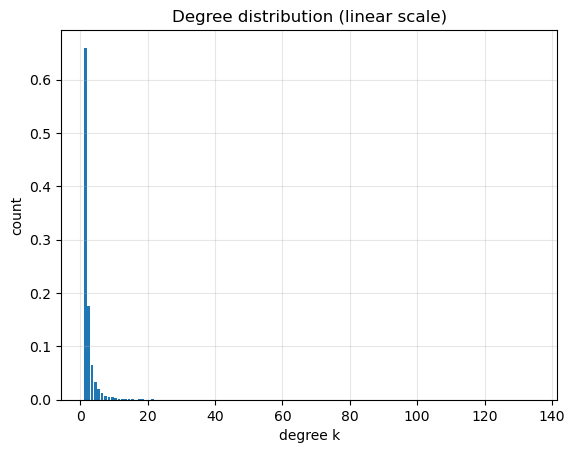

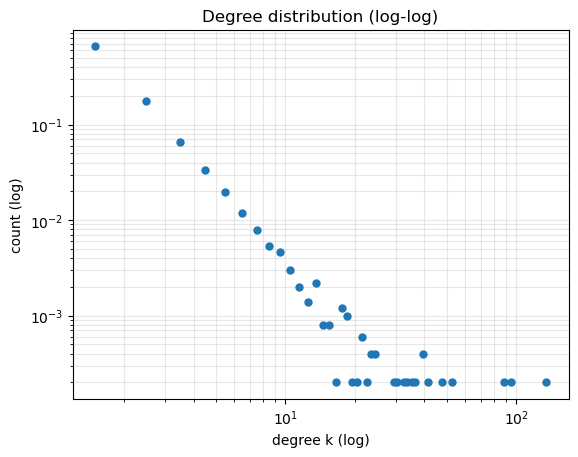

In [6]:
# To make it reproducible
random.seed(42)
np.random.seed(42)

# Creating a graph
G = nx.Graph()
G.add_edge(0,1)

next_node = 2

while G.number_of_nodes() < 5000:
    G.add_node(next_node)
    
    # Builds a list of edge endpoints, nodes appear as many times as their degree
    edge_ends = [n for (u,v) in G.edges() for n in (u,v)]

    # Picking a random target
    target = random.choice(edge_ends)

    # Attaching the new node to the target
    G.add_edge(next_node, target)
    next_node +=1


# What is the maximum and minimum degree?
degree_values = [d for _, d in G.degree()]
deg_min = min(degree_values)
deg_max = max(degree_values)
print(f"Minimum degree: {deg_min}")
print(f"Maximum degree: {deg_max}")


# Binning with numpy.histogram 
bins = np.arange(deg_min, deg_max+2)
counts, bin_edges = np.histogram(degree_values, bins=bins, density=True)

# Using bin center for plotting at the degree values
k_vals = (bin_edges[:-1] + bin_edges[1:]) / 2.0


# Plotting the distribution with linear axes
plt.figure()
plt.bar(k_vals, counts, width=0.8, align='center')
plt.xlabel("degree k")
plt.ylabel("count")
plt.title("Degree distribution (linear scale)")
plt.grid(True, alpha=0.3)
plt.show()


# Plotting the distribution with log-log axes
mask = (counts > 0) & (k_vals > 0)
plt.figure()
plt.loglog(k_vals[mask], counts[mask], "o", ms=5)
plt.xlabel("degree k (log)")
plt.ylabel("count (log)")
plt.title("Degree distribution (log-log)")
plt.grid(True, which="both", alpha=0.3)
plt.show()

# Assignment 1.2: Stats and visualization of the Rock Music Network

This second part requires you to have built the network of Rock Musicians as described in the exercises for Week 4. You should complete the following exercise from **Part 2**.

* *Explain your process in words*

* *Simple network statistics and analysis*.

  * **Note related to this and the following exercise**. It is nice to have the dataset underlying the statistics and visualization available when we grade. Therefore, I recommend that you create a small *network dataset*, which is simply your graph stored in some format that you like (since it's only a few hundred nodes and a few thousand edges, it won't take up a lot of space). You can then place that network one of your group members' GitHub account (or some other server that's available online) and have your Jupyter Notebook fetch that dataset when it runs. (It's OK to use an LLM for help with setting this up, if it seems difficult). 

And the following exercise from **Part 3**

* *Let's build a simple visualization of the network*

And that's it! You're all set.

# Assignment 1.2
## Part 2: Building the Networks
### 2.1: Setting up the Graph
- This is not part of the assignment, it is only added for the sake of completeness.
- If you want to skip this, go to 2.2.
#### 2.1.1: Defining some function for easier link extraction using regular expressions
We define three function in this part:
1. get_links: This function extracts the links from a page.
2. sanitize_string: This function sanitizes the links from a link. This basically just formats the way we save the links. As some band names would hurt the OS conventions, thus we couldn't save the corresponding musician name in a file. For example: 'AC/DC'.
3. sanitize_list: This function just sanitizes a list of strings.

In [7]:
def get_links(page: str) -> list:
    return re.findall(r"\[\[([^\[\]]*)\]\]",page)

def sanitize_string(name: str) -> str:
    return name.replace('/','_').replace(' ','_')

def sanitize_list(names: list[str]) -> list[str]:
    return [sanitize_string(x) for x in names]

#### 2.1.2 Calling Wikipedia API and Extracting the Wikitext of the Main Page
We define an another function for extracting the wikitext of a wikipedia page.

In [29]:
API = "https://en.wikipedia.org/w/api.php"
HEADERS = {"User-Agent": "MyWikipediaClient/1.0 (example@example.com)"}


# This method is based on this: https://stackoverflow.com/a/62225015 and this line was partly done with ChatGPT data["query"]["pages"][0]["revisions"][0]["slots"]["main"]["content"].
def get_wikitext(title: str) -> str:
    params = {
        "action": "query",
        "prop": "revisions",
        "titles": title,
        "rvslots": "main",
        "rvprop": "content",
        "format": "json",
        "formatversion": "2",
    }

    response = requests.get(API, params=params, headers=HEADERS, timeout=20)
    response.raise_for_status()

    data = response.json()

    return data["query"]["pages"][0]["revisions"][0]["slots"]["main"]["content"]

In [9]:
main_page = get_wikitext('List of mainstream rock performers')
print(main_page[0:100] + "\n")

rock_pages = re.findall(r'\[\[([^\[\]]*)\]\]', main_page)

rock_pages = sanitize_list(rock_pages)
print(rock_pages[0:10])

{{short description|None}}

This is an alphabetical '''list of mainstream rock performers''' spannin

['rock_music', '10cc', '10_Years_(band)|10_Years', '3_Doors_Down', '311_(band)|311', '38_Special_(band)|.38_Special', 'ABBA', 'Accept_(band)|Accept', 'AC_DC', 'Bryan_Adams']


#### 2.1.3: Downloading the Pages and Extracting the Links from those Pages
Download pages:
**Remark:** This part can take a while to execute. (Reference: ran 3-5 minutes locally)

In [3]:
for musician in rock_pages:
    musician_page = get_wikitext(musician)

    os.makedirs("./Misc/RockPages", exist_ok=True)

    with open(f'./Misc/RockPages/{musician}.txt', 'w') as output:
        output.write(musician_page)

print(os.listdir('./Misc/RockPages'))

NameError: name 'rock_pages' is not defined

Extracting links:


In [54]:
G = nx.DiGraph()
musicians = os.listdir('./Misc/RockPages')

for musician in musicians:
    with open(f'./Misc/RockPages/{musician}') as f:
        text = f.read()

    # Remove .txt from the end
    p_name = os.path.splitext(musician)[0]

    # It is actually important to add it here too, as some musicians have no links to other musicians
    # Furthermore, it is just easier to save the length of page here
    G.add_node(p_name, attr=len(text.split()))

    links = get_links(text)
    links = sanitize_list(links)

    # Only save edges where the link goes to a musician
    filtered_links = [link for link in links if link + ".txt" in musicians]
    print(filtered_links)

    for link in filtered_links:
        G.add_edge(p_name,link)

['Parliament-Funkadelic', 'AllMusic', 'Jimi_Hendrix', 'Parliament-Funkadelic', 'Sly_and_the_Family_Stone', 'Parliament-Funkadelic', 'Cream_(band)|Cream']
['Metallica', 'Megadeth', 'Anthrax_(American_band)|Anthrax', 'Iron_Maiden', 'Black_Sabbath', 'Judas_Priest', 'AllMusic', 'Scorpions_(band)|Scorpions', 'Iron_Maiden', 'Megadeth', 'AllMusic', 'Judas_Priest', 'Motörhead', 'Megadeth', 'Anthrax_(American_band)|Anthrax', 'Alice_in_Chains', 'Metallica', 'Ozzy_Osbourne', 'Sepultura', 'Black_Sabbath', 'Pantera', 'Tool_(band)|Tool', 'Slipknot_(band)|Slipknot', 'Metallica', 'Lamb_of_God_(band)|Lamb_of_God', 'Trivium_(band)|Trivium', 'Megadeth', 'Anthrax_(American_band)|Anthrax', 'Anthrax_(American_band)|Anthrax', 'Lamb_of_God_(band)|Lamb_of_God', 'Lamb_of_God_(band)|Lamb_of_God', 'Anthrax_(American_band)|Anthrax', 'Primus_(band)|Primus', 'Anthrax_(American_band)|Anthrax', 'Volbeat', 'Metallica', 'Megadeth', 'Black_Sabbath', 'AllMusic', 'AllMusic', 'Black_Sabbath', 'Motörhead', 'Judas_Priest', 'I

Remove disconnected nodes:

In [55]:
print(f"The graph before cutting:\n{G}")
nodes = list(G.nodes())

for node in nodes:
    if G.in_degree(node) == 0 and G.out_degree(node) == 0:
        G.remove_node(node)
        print(node)

print(f"The graph after cutting:\n{G}")

The graph before cutting:
DiGraph with 492 nodes and 7004 edges
Kaleo_(band)|Kaleo
Dr._Hook_&_the_Medicine_Show
Shakin'_Stevens
Category:Lists_of_rock_musicians
Van_Zant_(band)
Stevie_Ray_Vaughan|Stevie_Ray_Vaughan_and_Double_Trouble
Bread_(band)|Bread
Jet_(Australian_band)|Jet
Category:Lists_of_rock_musicians_by_subgenre
The graph after cutting:
DiGraph with 483 nodes and 7004 edges


Saving the network:

In [10]:
pickle.dump(G, open('Misc/MusicianGraph.pickle', 'wb'))

For easier grading:

In [11]:
url = 'https://raw.githubusercontent.com/hoboldi/Social-Graphs-and-Interactions/main/Misc/MusicianGraph.pickle'
r = requests.get(url)
r.raise_for_status()

G = pickle.load(BytesIO(r.content))
print(G)

DiGraph with 483 nodes and 7004 edges


Extracting the largest connected component:

In [12]:
LCG = max(nx.weakly_connected_components(G), key=len)
LCG = G.subgraph(LCG).copy()

### 2.2 Explanation
**Excercise:** Explain your process in words
- Document how you crawled the network.
    - **Q:** First, simply describe the steps of the process (what you did, step by step)
    - **A:** Queried Wikipedia for
    - **Q:** Then, write a short section about which part of the process that was most difficult
    - **A:**
        - Achieving clean Wikitext pages was not difficult, but finding the correct approach took a long time.
        - As I have worked with regular expression previously, that part was not that hard.
        - Networkx has a lot of convenient functions, so working with it was also not that complicated, but sometimes it took a long time trying something before realizing NetworkX has already a function for that.
    - **Q:** Next write a short section about how you used LLMs to help you
    - **A:** It helped a lot for the API part. Furthermore, it was useful for getting to know the syntax.
    - **Q:** Finally, compose a short section about what you would do differently if you had to do it again.
    - **A:** I am actually happy with my implementation, one thing I might consider improving ist extraction process for the links as some obvious not performers are kept inside the graph.

### 2.3 Network Statistics and Analysis
**Exercises:** Simple network statistics and analysis
- **Q:** What is the number of nodes in the network?
- **A:** 483, see code.
- **Q:** More importantly, what is the number of links?
- **A:** 7004, see code.

In [13]:
print(LCG)

DiGraph with 483 nodes and 7004 edges


- **Q:** Plot the in and out-degree distributions for the entire network.
- **A:**

7004
7004


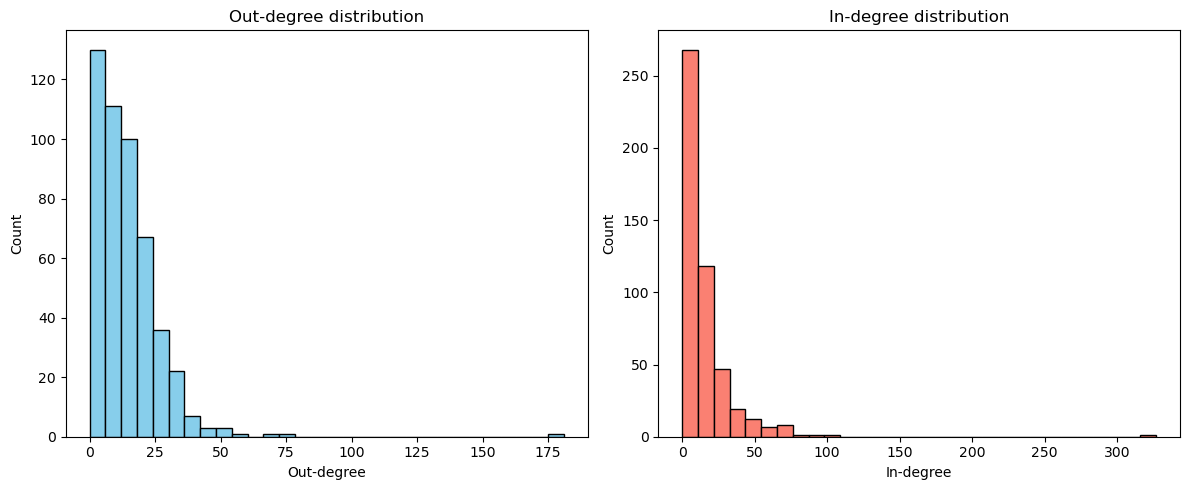

In [14]:
# get the degrees
in_degrees  = [d for _, d in LCG.in_degree()]
out_degrees = [d for _, d in LCG.out_degree()]

print(sum(in_degrees))
print(sum(out_degrees))

# plot
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.hist(out_degrees, bins=30, color="skyblue", edgecolor="black")
plt.title("Out-degree distribution of the real network")
plt.xlabel("Out-degree")
plt.ylabel("Count")

plt.subplot(1,2,2)
plt.hist(in_degrees, bins=30, color="salmon", edgecolor="black")
plt.title("In-degree distribution of the real network")
plt.xlabel("In-degree")
plt.ylabel("Count")

plt.tight_layout()
plt.show()

**Image 2.1:
The out- and in-degree distribution of our created network**

X-axis is the out- and in-degree.
Y-axis is the number of nodes with the given degree.

 - **Q:** What do you observe?
 - **Q:** Can you explain why the in-degree distribution is different from the out-degree distribution?

**Explanation:**
- There is a select few bands who are the most influential. These influenced the most bands on the list.
- This explains why there is fewer "low in-degree bands", but more "high in-degree bands".
- Most bands reference these select few.
- This explains the lower variance of the out-degree distribution.
- This is the typical phenomenon discovered by Barabási-Albert László.
- These are the Hubs of this network.

- Compare the out-degree distribution to a *random network* with the same number of nodes and links.

DiGraph with 483 nodes and 7004 edges


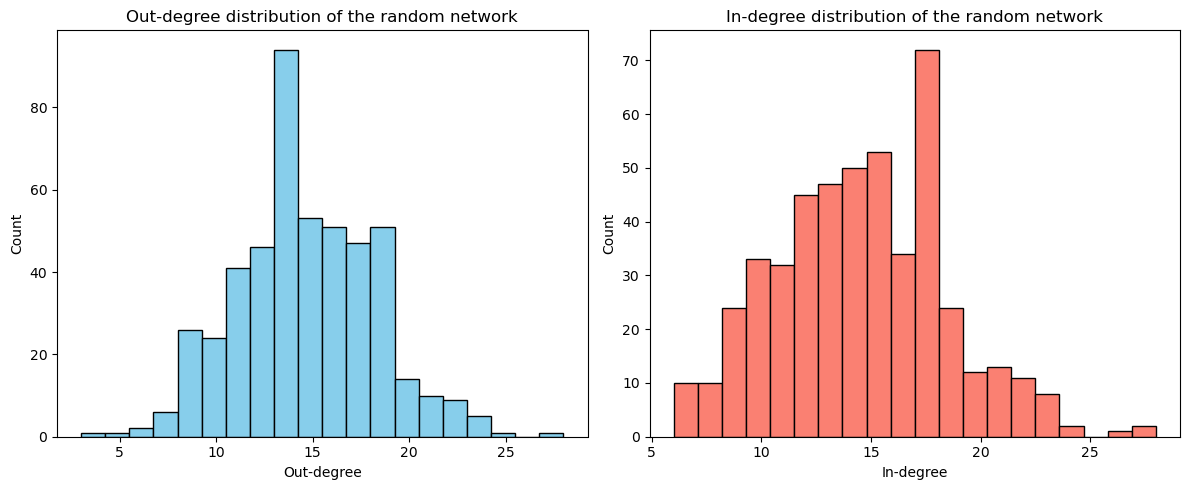

In [30]:
# create the random graph
random = nx.gnm_random_graph(n=LCG.number_of_nodes(),m=LCG.number_of_edges(),directed=True)
print(random)

# get the degrees
in_degrees  = [d for _, d in random.in_degree()]
out_degrees = [d for _, d in random.out_degree()]

# plot
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.hist(out_degrees, bins=20, color="skyblue", edgecolor="black")
plt.title("Out-degree distribution of the random network")
plt.xlabel("Out-degree")
plt.ylabel("Count")

plt.subplot(1,2,2)
plt.hist(in_degrees, bins=20, color="salmon", edgecolor="black")
plt.title("In-degree distribution of the random network")
plt.xlabel("In-degree")
plt.ylabel("Count")

plt.tight_layout()
plt.show()

**Image 2.2:
The out- and in-degree distribution of a random network with the same size as our created network**

X-axis is the out- and in-degree.
Y-axis is the number of nodes with the given degree.

**Comparison:**
- The distribution of the out-degrees is vastly different compared to our network.
- The degrees follow a normal-like distribution, and not the Barabási-like distribution.

- Compare the in-degree distribution to a *scale-free* network with the same number of nodes.

MultiDiGraph with 483 nodes and 1021 edges


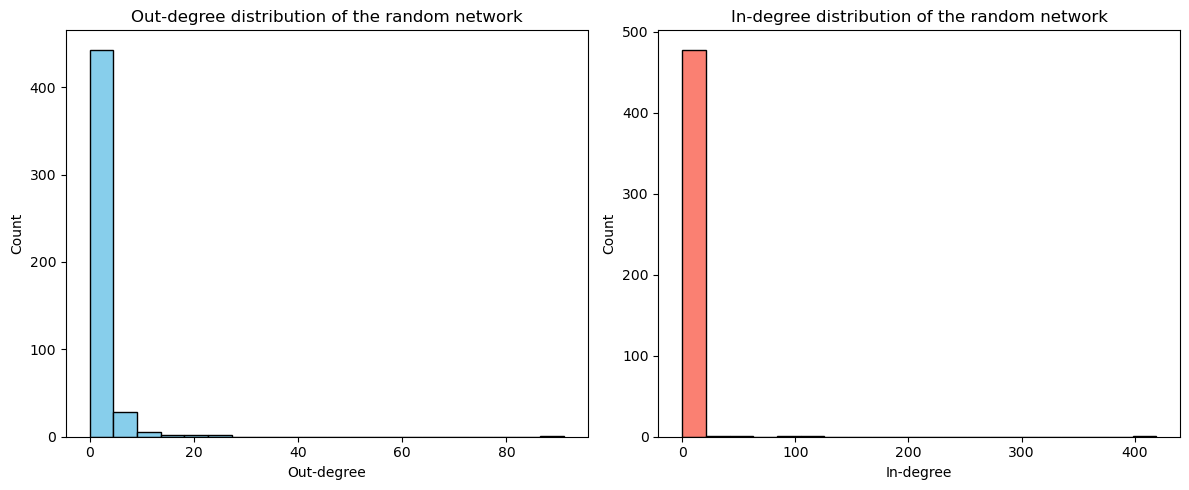

In [33]:
# nodes
n = LCG.number_of_nodes()

# create the graph
scale_free = nx.scale_free_graph(n=n)
print(scale_free)

# get the degrees
in_degrees  = [d for _, d in scale_free.in_degree()]
out_degrees = [d for _, d in scale_free.out_degree()]

# plot
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.hist(out_degrees, bins=20, color="skyblue", edgecolor="black")
plt.title("Out-degree distribution of the random network")
plt.xlabel("Out-degree")
plt.ylabel("Count")

plt.subplot(1,2,2)
plt.hist(in_degrees, bins=20, color="salmon", edgecolor="black")
plt.title("In-degree distribution of the random network")
plt.xlabel("In-degree")
plt.ylabel("Count")

plt.tight_layout()
plt.show()

**Image 2.3:
The out- and in-degree distribution of a scale-free network with the same size as our created network**

X-axis is the out- and in-degree.
Y-axis is the number of nodes with the given degree.

**Comparison:**
- This is much more similar to our network.
- However, this is still different to our graph as this distribution is much more skewed.
- There is only a few (very huge) hubs and a lot of normal nodes.

- Who are the top 5 most connected performers (Report results for in-degrees and out-degrees, that is, who has highest in-degree, who has highest out-degree)? Comment on your findings. Is this what you would have expected?

In [17]:
# These lambda expressions were generated by ChatGPT as my implementation was much longer and not so nice.
top_in = sorted(LCG.in_degree(), key=lambda x: x[1], reverse=True)[:5]
top_out = sorted(LCG.out_degree(), key=lambda x: x[1], reverse=True)[:5]

print("In-degree:")
for node, deg in top_in:
    print(f"{node}: {deg}")

print()

print("Out-degree:")
for node, deg in top_out:
    print(f"{node}: {deg}")

print()

In-degree:
AllMusic: 327
Led_Zeppelin: 108
Bob_Dylan: 90
Queen_(band)|Queen: 80
Metallica: 76

Out-degree:
rock_music: 181
Alice_in_Chains: 74
Deep_Purple: 72
Black_Sabbath: 59
Guns_N'_Roses: 49



**Explanation:**
- This is close to the expected result. We have the most influential bands with the highest in-degree, and it makes sense as these bands influenced a lot of bands and the wiki page of the musicians link to the musicians who have influenced them.
- The out-degree is also reasonable as these bands have been all influenced by a lot of different musicians and have all played varying music.

- What are the 10 pages with the longest wiki entries? (use the `length of content` attribute to figure this one out)?

In [18]:
# This lambda expression was generated by ChatGPT as my implementation was much longer and not so nice.
pages = sorted(
    LCG.nodes(data=True),
    key=lambda x: list(x[1].values())[0],  # grab the only attribute value
    reverse=True
)[:10]

print(pages)

[('Bob_Dylan', {'attr': 30646}), ("Guns_N'_Roses", {'attr': 29711}), ('Paul_McCartney', {'attr': 27322}), ('The_Rolling_Stones', {'attr': 26186}), ('Chicago_(band)|Chicago', {'attr': 25975}), ('Europe_(band)|Europe', {'attr': 25273}), ('David_Bowie', {'attr': 24905}), ('Elton_John', {'attr': 24904}), ('U2', {'attr': 24877}), ('The_Beach_Boys', {'attr': 24844})]


## Part 3: Visualizing the Networks
**Exercises:** Let's build a simple visualization of the network.
1. For the sake of the visualisation, let's convert our network to *undirected graph* (tip: There is a NetworkX command to help you).
   * *Note*: Keep the directed graph, we will use it in the following exercises.
2. Use the NetworkX command `nx.spring_layout` or `nx.draw_kamada_kawai` to draw the resulting undirected network. (You can find [background on the algorithms here](https://en.wikipedia.org/wiki/Force-directed_graph_drawing).)
   * Set up your plot so that node-size depends on the node *degree*.
   * Make the node color depend on the `length of content` attribute. I recommend choosing a color scheme that is quite simple (e.g. the Sequential ones here: https://matplotlib.org/stable/users/explain/colors/colormaps.html)

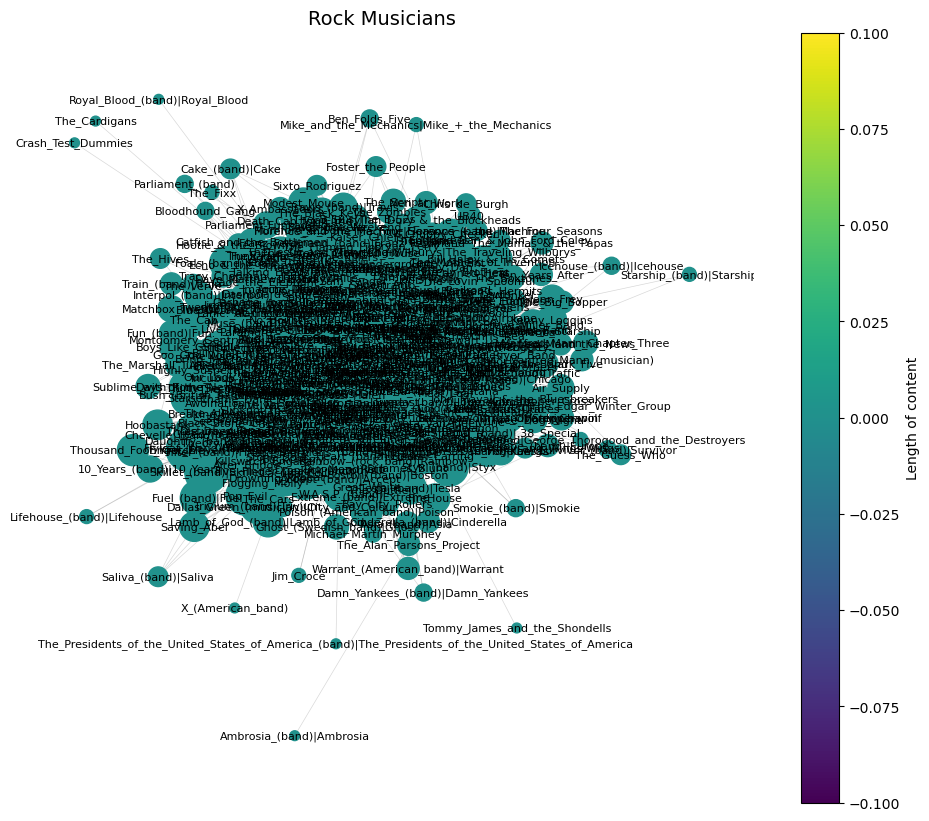

In [36]:
# change to undirected
undirected = LCG.to_undirected()

pos = nx.spring_layout(undirected, seed=42)

# make the size of the nodes dependent on the degrees
degrees = dict(undirected.degree())
node_sizes = [degrees[n] * 50 for n in undirected.nodes()]

# make the color depend on the length of content
lengths = nx.get_node_attributes(undirected, "length of content")
node_colors = [lengths.get(n, 0) for n in undirected.nodes()]

# create the plot
plt.figure(figsize=(12, 10))
nodes = nx.draw_networkx_nodes(
    undirected,
    pos,
    node_size=node_sizes,
    node_color=node_colors,
    cmap=plt.cm.viridis,
    alpha=1,
    vmin=min(node_colors),
    vmax=max(node_colors)
)

nx.draw_networkx_edges(undirected, pos, alpha=0.3, edge_color="gray", width=0.5)
nx.draw_networkx_labels(undirected, pos, font_size=8)

plt.colorbar(nodes, label="Length of content")
plt.axis("off")
plt.title("Rock Musicians", fontsize=14)
plt.show()

**Image 2.4:
The visualization of our network**

- The network is converted to an undirected network.
- Size of the node depends on the number of edges.
- The color of the node depends on the length of the given wiki page.

### Who has done what?
- Name: Assigment 1.1 Part 1
- Mari Piiriste: Assigment 1.1 Part 2
- Boldizsár Zalán Horváth: Assigment 1.2